# Deep Learning on Graph Data:

In this presentation we use Tensorflow to detect fraudulent graph structures. 

In [4]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
# import seaborn as sns
import itertools as it
import random

from scipy.misc import logsumexp

In [5]:
# create new session if we need it
sess = tf.Session()

In [6]:
def generate_graphs(n, min_nodes=10, max_nodes=200, y=1):
    # Code to generate n random graphs
    
    graphset = []
    
    for i in range(n):

        # Assigning number of nodes randomly between 1-200
        n_nodes = random.randint(min_nodes,max_nodes)
        
        # Modelling the resource allocation with Normal Distrib - mean: m, and stddev = s
        p = 0.2       
        m = 20
        s = 0.25

#         G_rand = nx.duplication_divergence_graph(n_nodes, p, 1, directed=True)
#         G_rand = nx.gnr_graph(n_nodes,p)
#         G_rand = nx.powerlaw_cluster_graph(n_nodes,4,0.1)
        G_rand = nx.gnc_graph(n_nodes)
    
        # make sure all nodes have outdegree of at least 1
        outds = G_rand.out_degree().values()
        for i, outd in enumerate(outds):
            if outd == 0 or y != 1:
                valid_inds = range(0,i) +\
                                    range(i+1,n_nodes)
#                 print i, valid_inds
                G_rand.add_edge(i, 
                                random.choice(valid_inds))

        graphset.append(G_rand)
    
    return graphset

In [7]:
def displayGraph(graph):
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph, pos)
    nx.draw_networkx_edges(graph, pos, arrows=True)
    nx.draw_networkx_labels(graph,pos)
    plt.title('Graphs generated')
    plt.show()

In [6]:
def pageRank_allocation(G):
    
    # Calculate PageRank here
    pr = nx.pagerank(G)
    
    # Assign PageRank values here
    for i in G:
        node = G.node[i]
        page_rank_value = pr[i]
        node['PageRank'] = tf.constant(page_rank_value)
        node['pr'] = pr[i]
    return pr.values()

In [8]:
# At this stage you have a list of Graphs containing random nodes from 1-200
# Each node has a tensorFlow constant value attached to it signifying its PageRank score

# first calc K, A, M
def pagerank(graph, damping=0.85):
    N = nx.number_of_nodes(graph)
    A = nx.to_numpy_matrix(graph)
    k = graph.out_degree().values()
    K = np.diag(k)
    M = (np.matmul(np.linalg.inv(K),A)).T
    R = np.matmul(np.linalg.inv(np.identity(N) - damping*M),\
        (1.0 - damping)/N * np.ones((N,1)))
    
    for i in graph.node:
        print R[i], graph.node[i]['pr']
    

    
pagerank(generate_graphs)

NameError: name 'graphset' is not defined

In [55]:
def gen_test1():
    n = 10
    thresh = 3.05
    graphs = generate_graphs(n, min_nodes=20, 
                           max_nodes=20,y=1) +\
             generate_graphs(n, min_nodes=20, 
                           max_nodes=20,y=-1) 
    As = []
    ys = []
    ks = []
    
    scores = []
    for graph in graphs:
        pr = pageRank_allocation(graph)
        scores.append(logsumexp(np.array(pr)))
    
    scores_sorted = sorted(scores)
    thresh = scores_sorted[-4]
        
    for i, graph in enumerate(graphs):
        if scores[i] > thresh:
            ys.append(1)
        else:
            ys.append(-1)
        
        
        As.append(nx.to_numpy_matrix(graph))
        ks.append(graph.out_degree().values())
        
    return As, ys, ks, graphs
        
As, ys, ks, graphs = gen_test1()

In [56]:
def tf_pagerank(n, damping=0.85):
#     N = nx.number_of_nodes(graph)
#     A = nx.to_numpy_matrix(graph)
#     k = graph.out_degree().values()
    d = tf.constant(damping)
    N = tf.constant(n, dtype=tf.float32)
    A = tf.placeholder(tf.float32, shape=(n,n))
    k = tf.placeholder(tf.float32, shape=(n,))
    kinv = tf.div(tf.ones((n,), tf.float32), k)
    Kinv = tf.diag(kinv)
    I2 = tf.eye(n)
    M = tf.transpose(tf.matmul(Kinv, A))
    Minv = tf.matrix_inverse(I2 - d*M)
    R = tf.matmul(Minv,\
        tf.multiply((1.0 - damping)/N, tf.ones((n,1))))
    
    return R, A, k

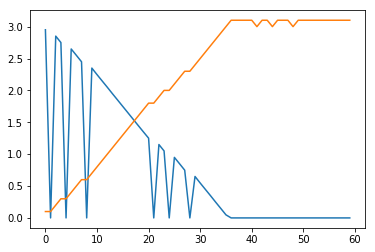

In [63]:
def opt_pgrank(As, ys, ks):
    thresh = tf.Variable(0.0, name='threshold')
    R, A, k = tf_pagerank(20)
    y = tf.placeholder(tf.float32, shape=())
    
    cost = tf.nn.relu(tf.multiply(y, (thresh - tf.reduce_logsumexp(R))))
    
    optimizer = tf.train.GradientDescentOptimizer(0.1)
    trainer = optimizer.minimize(cost)
    
    # get things ready
    sess.run(tf.global_variables_initializer())
    
    epochs = 3
    loss = []
    thresh_hist = []
    for epoch in range(epochs):
        for i in range(len(ys)):
            sess.run(trainer, feed_dict={A : As[i], y : ys[i], k : ks[i]})
            loss.append(sess.run(cost, feed_dict={A : As[i], y : ys[i], k : ks[i]}))
            thresh_hist.append(sess.run(thresh, feed_dict={A : As[i], y : ys[i], k : ks[i]}))
    plt.plot(loss)
    plt.plot(thresh_hist)
    plt.show()
        
opt_pgrank(As, ys, ks)